# GET DATASET

In [1]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.datasets import fetch_mldata
from IPython.display import display
mnist = fetch_mldata('MNIST original')
X,y = mnist['data'],mnist['target']
print(X.shape,y.shape)

(70000, 784) (70000,)


# DISPLAYING ONE NUMBER

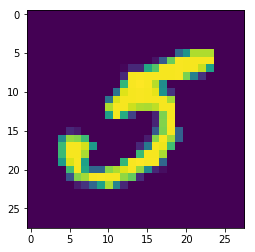

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
digit = X[36000]
image = digit.reshape(28,-1)
plt.imshow(image,shape=(28,28))

In [3]:
#what does the data say the above is?
display(y[36000])

5.0

# TRAIN AND TEST SETS

In [4]:
X_train,y_train,X_test,y_test = X[:60000],y[:60000],X[60000:],y[60000:]
#shuffle the training set within itself
import numpy as np
indices = np.random.permutation(60000)
X_train = X_train[indices]
y_train = y_train[indices]
display(X_train)
display(y_train)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

array([5., 6., 3., ..., 2., 6., 2.])

# 5 DETECTOR

In [5]:
y_train5 = (y_train == 5)
y_test5 = (y_test == 5)
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train,y_train5)
sgd_clf.predict([digit])

array([ True])

# ACCURACY

In [6]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(sgd_clf,X_train,y_train5,scoring="accuracy",cv=3)
print(scores)

[0.9667 0.9548 0.9671]


# NOT 5 CLASSIFIER (ASSUMING ALL ARE NOT 5)
## to disprove the usefullness of accuracy in skewed datasets

In [7]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self,X,y):
        pass
    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool)
never5clf = Never5Classifier()
never5score = cross_val_score(never5clf,X_train,y_train5,scoring='accuracy',cv=3)
print(never5score)

[0.908   0.90925 0.9117 ]


# CONFUSION MATRIX (precision/recall)

In [8]:
from sklearn.model_selection import cross_val_predict
preds = cross_val_predict(sgd_clf,X_train,y_train5,cv=3)
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_train5,preds)
mat

array([[54096,   483],
       [ 1745,  3676]])

# PRECISION/RECALL/F1 SCORE

In [9]:
# precision TP/(TP+FP)
# recall TP/(TP+FN)
from sklearn.metrics import precision_score,recall_score
display(precision_score(y_train5,preds))
display(recall_score(y_train5,preds))

0.8838663140177927

0.6781036709094264

In [10]:
from sklearn.metrics import f1_score
display(f1_score(y_train5,preds))

0.7674321503131525

# PRECISION/RECALL TRADEOFF

In [11]:
#for a specific example
yscores = sgd_clf.decision_function([digit])
threshold=0
digitpred = yscores>threshold
display("when threshold=0, ",digitpred)
threshold=200000
digitpred = yscores>threshold
display("when threshold=200000, ",digitpred)

'when threshold=0, '

array([ True])

'when threshold=200000, '

array([False])

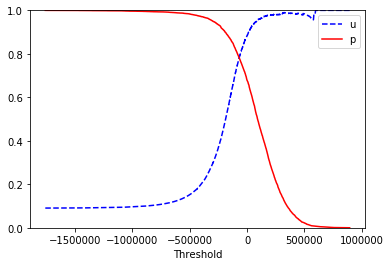

In [12]:
#general
yscores = cross_val_predict(sgd_clf,X_train,y_train5,cv=3,method='decision_function')
from sklearn.metrics import precision_recall_curve
prec,rec,thresh = precision_recall_curve(y_train5,yscores)
def plot_prec_rec_thresh(prec,rec,thresh):
    plt.plot(thresh,prec[:-1],'b--',label='precision')
    plt.plot(thresh,rec[:-1],'r-',label='recall')
    plt.xlabel('Threshold')
    plt.legend('upper left')
    plt.ylim([0,1])
plot_prec_rec_thresh(prec,rec,thresh)
plt.show()

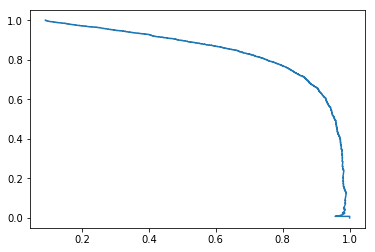

In [13]:
# p/r curve
plt.plot(prec[:-1],rec[:-1],)
plt.show()

# REQ: 90% precision

In [14]:
y_train_pred_90 = (yscores > 5000)
display(precision_score(y_train5,y_train_pred_90))
display(recall_score(y_train5,y_train_pred_90))

0.8889700511322133

0.673491975650249

# ROC CURVE & ROC AUC SCORE

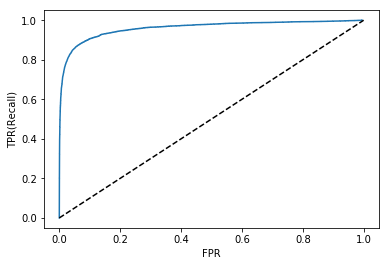

In [15]:
from sklearn.metrics import roc_curve
fpr,tpr,thresholds = roc_curve(y_train5,yscores)
plt.plot(fpr[:-1],tpr[:-1])
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR')
plt.ylabel('TPR(Recall)')
plt.show()

In [16]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_train5,yscores)
print(auc)

0.9602880507157471


# COMPARE FOREST AND SGD

In [17]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier()
forest_probs = cross_val_predict(X=X_train,cv=3,estimator=forest_clf,y=y_train5,method='predict_proba')
display(forest_probs[:,1])

array([1., 0., 0., ..., 0., 0., 0.])

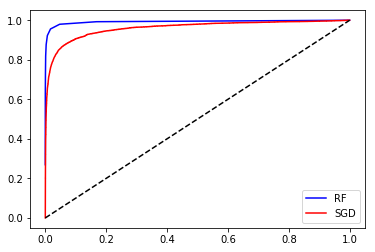

In [18]:
yscoresf = forest_probs[:,1]
fprf,tprf,threshf = roc_curve(y_train5,yscoresf)
plt.plot(fprf,tprf,'b',label='RF')
plt.plot(fpr,tpr,'r',label='SGD')
plt.plot([0,1],[0,1],'k--')
plt.legend(loc='bottom right')
plt.show()

In [19]:
aucf = roc_auc_score(y_train5,yscoresf)
display(aucf)

0.9926644581700067

In [20]:
preds = cross_val_predict(X=X_train,cv=3,estimator=forest_clf,y=y_train5)
s = precision_score(y_train5,preds)
display(s)
s = recall_score(y_train5,preds)
display(s)

0.9845947756195579

0.813503043718871

# MULTICLASS CLASSIFICATION

In [21]:
sgd_clf.fit(X_train,y_train)
sgd_clf.predict([digit])

array([5.])

In [22]:
digit_score = sgd_clf.decision_function([digit])
digit_score

array([[   7832.15618102, -428722.7280291 , -309076.83323942,
        -172743.3604965 , -461145.09232473,   77372.17499853,
        -767443.3470822 , -305802.7916911 , -501792.58590679,
        -509495.42174625]])

In [23]:
np.argmax(digit_score)

5

In [24]:
#ENFORCING OVA/OVO
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train,y_train)
ovo_clf.predict([digit])

array([5.])

In [25]:
len(ovo_clf.estimators_)

45

In [26]:
forest_clf.fit(X_train,y_train)
forest_clf.predict_proba([digit])

array([[0. , 0. , 0.1, 0. , 0. , 0.9, 0. , 0. , 0. , 0. ]])

In [27]:
x=forest_clf.predict_proba([digit])
x[0,5]

0.9

In [28]:
cross_val_score(sgd_clf,X_train,y_train,cv=3,scoring='accuracy')

array([0.85937812, 0.82359118, 0.85302795])

In [29]:
# standardizing
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf,X_train_scaled,y_train,cv=3,scoring='accuracy')

array([0.90866827, 0.91079554, 0.90873631])

# ERROR ANALYSIS

In [30]:
y_train_preds = cross_val_predict(sgd_clf,X_train_scaled,y_train,cv=3)
conf_mat = confusion_matrix(y_train,y_train_preds)
conf_mat

array([[5731,    3,   25,   12,   10,   44,   48,    9,   37,    4],
       [   2, 6482,   43,   27,    6,   45,    6,   12,  106,   13],
       [  57,   41, 5332,   95,   83,   21,   96,   57,  158,   18],
       [  50,   42,  142, 5342,    3,  234,   38,   53,  124,  103],
       [  19,   23,   38,    8, 5361,   13,   55,   33,   85,  207],
       [  70,   38,   34,  184,   68, 4616,  114,   33,  172,   92],
       [  31,   24,   42,    3,   41,   94, 5629,    6,   47,    1],
       [  24,   19,   65,   31,   53,   11,    6, 5773,   12,  271],
       [  48,  154,   70,  160,   16,  166,   59,   27, 5002,  149],
       [  40,   33,   25,   88,  169,   41,    2,  178,   77, 5296]])

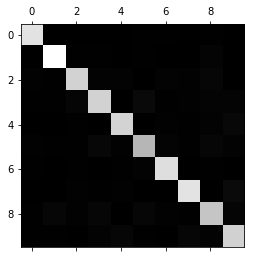

In [31]:
plt.matshow(conf_mat,cmap=plt.cm.gray)

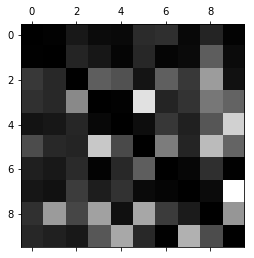

In [32]:
rowsums = conf_mat.sum(axis=1,keepdims=True)
norm_conf_mat = conf_mat/rowsums
np.fill_diagonal(norm_conf_mat,0)
plt.matshow(norm_conf_mat,cmap=plt.cm.gray)
#0-black, 1-white

In [33]:
#viewing some examples
# cl_a,cl_b = 3,5
# X_aa = X_train[(y_train==cl_a)&(y_train_preds==cl_a)]
# X_ab = X_train[(y_train==cl_a)&(y_train_preds==cl_b)]
# X_ba = X_train[(y_train==cl_b)&(y_train_preds==cl_a)]
# X_bb = X_train[(y_train==cl_b)&(y_train_preds==cl_b)]
# plt.figure(figsize=(8,8))
# plt.subplot(221); plot_digits(X_aa[:25],images_per_row=5)
# plt.subplot(222); plot_digits( X_ab [:25], images_per_row = 5)
# plt.subplot(223); plot_digits( X_ba [: 25], images_per_row = 5 )
# plt.subplot(224);plot_digits(X_bb [: 25 ],images_per_row = 5)
# plt.show()

# MULTILABEL CLASSIFICATION

In [ ]:
# from sklearn.neighbors import KNeighborsClassifier
# y_train_large = (y_train>7)
# y_train_odd = (y_train%2 == 1)
# y_multilabel = np.c_[y_train_large,y_train_odd]
# print('labels done')
# knn_clf = KNeighborsClassifier()
# knn_clf.fit(X_train,y_multilabel)
# print('fit done')
# print(knn_clf.predict([digit]))
# y_train_knn_pred = cross_val_predict(knn_clf,X_train,y_train,cv=3)
# f1_score(y_train,y_train_knn_pred,average='macro')

# MULTIOUTPUT CLASSIFICATION 

In [ ]:
noise = np.ra